# Introduction

pytorch is good

# motivation

He said this tutorial is comprehensive. lets see.

Pytorch is complete with autograd, dynamic computation graph, model classes etc

Lets go.

# Simple regression Problem

This part is to show you how pytorch work.

That's why this part is so simple.

## Data generation

Let's try generate data randomly here.

We know a =1  and b =2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

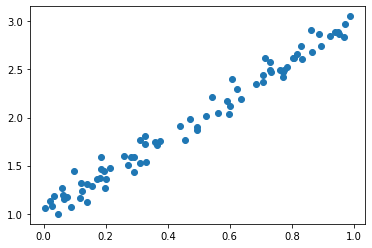

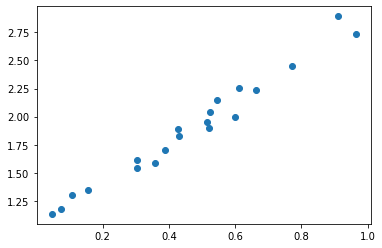

In [3]:
plt.scatter(x_train, y_train)
plt.show()

plt.scatter(x_val, y_val)
plt.show()

# Gradient Descent
## 1. compute loss

For this problem we use MSE

note : batch is N, 1 is stochastic, in between is mini-batch gradient descent

## 2. compute gradient descent

we partial derivative for every weight

it tells how much the weight affect the result

there is math formula for that.


## 3. Update the parameter.

since we want to minimize the loss then we have to reduce the variable(a and b) according to gradient descent

## 4. repeat

repeat for many epoch

note :  1 epoch equal 1 iterartion until all point used. if its bacth then 1 batch is 1 epoch, if it is stochastic then until N is 1 epoch

# Linear regression in Numpy

First we try to implement using numpy for learning purpose.

this is the code

In [4]:

# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


It's good.

now next is pytorch

# Pytorch

lets exaplain some basic concept

## Tensor

scalar = number
vector = 1 dimension
matrix = 2 dimension
Tensor = 3 or more dimension

sometimes vector and matrice called tensor as well

## Loading data device cuda

from_numpy to change numpy to tensor

to() to send tensor to GPU

cuda.is_available() to check if GPU exists




In [5]:
from platform import python_version

print(python_version())

3.7.3


In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [7]:
# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


you can see the type is different

however if you use type it will reveal its location

you can go back to numpy using numpy() but if you use cpu only


## Creating parameter

what diff tensor and data?

tensor need to compute gradient

lets go to code

In [8]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([2.3916], requires_grad=True) tensor([-0.9407], requires_grad=True)
tensor([-0.3325], device='cuda:0', grad_fn=<CopyBackwards>) tensor([-0.2274], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([-0.8194], device='cuda:0', requires_grad=True) tensor([-0.3259], device='cuda:0', requires_grad=True)


first one is not GPU..

second one is GPU but we lose the gradient somehow

third one is good one

note: in torch if the fun end with underscore it will replace the original variable

even the last approach is good there is better way

In [9]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


ok now we done create tensor that need's gradient next we compute the gradient.

## Autograd

This is for computing gradient forward and backward

We need backward function for computing loss

gradient are accumulated, after gradient used to update param, we need to make gradient zero again using zero_() with underscore.

lets do it, with backward and zero_(). without manual computation of gradient.

In [10]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.3881], device='cuda:0')
tensor([-1.9439], device='cuda:0')
tensor([-2.5268], device='cuda:0')
tensor([-1.5005], device='cuda:0')
tensor([-1.8796], device='cuda:0')
tensor([-1.1666], device='cuda:0')
tensor([-1.3935], device='cuda:0')
tensor([-0.9151], device='cuda:0')
tensor([-1.0283], device='cuda:0')
tensor([-0.7254], device='cuda:0')
tensor([-0.7541], device='cuda:0')
tensor([-0.5822], device='cuda:0')
tensor([-0.5483], device='cuda:0')
tensor([-0.4741], device='cuda:0')
tensor([-0.3938], device='cuda:0')
tensor([-0.3922], device='cuda:0')
tensor([-0.2780], device='cuda:0')
tensor([-0.3301], device='cuda:0')
tensor([-0.1912], device='cuda:0')
tensor([-0.2829], device='cuda:0')
tensor([-0.1262], device='cuda:0')
tensor([-0.2469], device='cuda:0')
tensor([-0.0777], device='cuda:0')
tensor([-0.2193], device='cuda:0')
tensor([-0.0414], device='cuda:0')
tensor([-0.1981], device='cuda:0')
tensor([-0.0144], device='cuda:0')
tensor([-0.1816], device='cuda:0')
tensor([0.0056], dev

tensor([0.0119], device='cuda:0')
tensor([-0.0233], device='cuda:0')
tensor([0.0117], device='cuda:0')
tensor([-0.0229], device='cuda:0')
tensor([0.0115], device='cuda:0')
tensor([-0.0226], device='cuda:0')
tensor([0.0114], device='cuda:0')
tensor([-0.0222], device='cuda:0')
tensor([0.0112], device='cuda:0')
tensor([-0.0219], device='cuda:0')
tensor([0.0110], device='cuda:0')
tensor([-0.0216], device='cuda:0')
tensor([0.0109], device='cuda:0')
tensor([-0.0212], device='cuda:0')
tensor([0.0107], device='cuda:0')
tensor([-0.0209], device='cuda:0')
tensor([0.0105], device='cuda:0')
tensor([-0.0206], device='cuda:0')
tensor([0.0104], device='cuda:0')
tensor([-0.0203], device='cuda:0')
tensor([0.0102], device='cuda:0')
tensor([-0.0200], device='cuda:0')
tensor([0.0101], device='cuda:0')
tensor([-0.0197], device='cuda:0')
tensor([0.0099], device='cuda:0')
tensor([-0.0194], device='cuda:0')
tensor([0.0098], device='cuda:0')
tensor([-0.0191], device='cuda:0')
tensor([0.0096], device='cuda:0')


tensor([-0.0037], device='cuda:0')
tensor([0.0019], device='cuda:0')
tensor([-0.0036], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0036], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0035], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0035], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0034], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0034], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0033], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0033], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0032], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0032], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0031], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0031], device='cuda:0')
tensor([0.0015], device='cuda:0')
tensor([-0.0030], device='cuda:0')
tensor([0.0015], device='cuda:0')
tensor([-0.0030], device='cuda:0')

tensor([-0.0005], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')
tensor([0.0002], device='cuda:0')
tensor([-0.0004], device='cuda:0')

tensor([-7.7181e-05], device='cuda:0')
tensor([3.8869e-05], device='cuda:0')
tensor([-7.5986e-05], device='cuda:0')
tensor([3.8201e-05], device='cuda:0')
tensor([-7.4878e-05], device='cuda:0')
tensor([3.7690e-05], device='cuda:0')
tensor([-7.3698e-05], device='cuda:0')
tensor([3.7032e-05], device='cuda:0')
tensor([-7.2627e-05], device='cuda:0')
tensor([3.6519e-05], device='cuda:0')
tensor([-7.1515e-05], device='cuda:0')
tensor([3.5852e-05], device='cuda:0')
tensor([-7.0485e-05], device='cuda:0')
tensor([3.5357e-05], device='cuda:0')
tensor([-6.9396e-05], device='cuda:0')
tensor([3.4759e-05], device='cuda:0')
tensor([-6.8387e-05], device='cuda:0')
tensor([3.4215e-05], device='cuda:0')
tensor([-6.7374e-05], device='cuda:0')
tensor([3.3793e-05], device='cuda:0')
tensor([-6.6286e-05], device='cuda:0')
tensor([3.3415e-05], device='cuda:0')
tensor([-6.5217e-05], device='cuda:0')
tensor([3.2903e-05], device='cuda:0')
tensor([-6.4227e-05], device='cuda:0')
tensor([3.2310e-05], device='cuda:0')

tensor([-1.5183e-05], device='cuda:0')
tensor([7.7696e-06], device='cuda:0')
tensor([-1.4850e-05], device='cuda:0')
tensor([7.4347e-06], device='cuda:0')
tensor([-1.4742e-05], device='cuda:0')
tensor([7.3607e-06], device='cuda:0')
tensor([-1.4507e-05], device='cuda:0')
tensor([7.2904e-06], device='cuda:0')
tensor([-1.4265e-05], device='cuda:0')
tensor([7.2028e-06], device='cuda:0')
tensor([-1.4039e-05], device='cuda:0')
tensor([7.1423e-06], device='cuda:0')
tensor([-1.3802e-05], device='cuda:0')
tensor([7.0538e-06], device='cuda:0')
tensor([-1.3573e-05], device='cuda:0')
tensor([6.8587e-06], device='cuda:0')
tensor([-1.3419e-05], device='cuda:0')
tensor([6.6655e-06], device='cuda:0')
tensor([-1.3267e-05], device='cuda:0')
tensor([6.4922e-06], device='cuda:0')
tensor([-1.3106e-05], device='cuda:0')
tensor([6.5039e-06], device='cuda:0')
tensor([-1.2854e-05], device='cuda:0')
tensor([6.5705e-06], device='cuda:0')
tensor([-1.2582e-05], device='cuda:0')
tensor([6.3824e-06], device='cuda:0')

tensor([-2.8972e-06], device='cuda:0')
tensor([1.5730e-06], device='cuda:0')
tensor([-2.8723e-06], device='cuda:0')
tensor([1.6266e-06], device='cuda:0')
tensor([-2.7751e-06], device='cuda:0')
tensor([1.6005e-06], device='cuda:0')
tensor([-2.7437e-06], device='cuda:0')
tensor([1.5683e-06], device='cuda:0')
tensor([-2.7182e-06], device='cuda:0')
tensor([1.5306e-06], device='cuda:0')
tensor([-2.7084e-06], device='cuda:0')
tensor([1.5143e-06], device='cuda:0')
tensor([-2.6734e-06], device='cuda:0')
tensor([1.5344e-06], device='cuda:0')
tensor([-2.6140e-06], device='cuda:0')
tensor([1.5260e-06], device='cuda:0')
tensor([-2.5649e-06], device='cuda:0')
tensor([1.5139e-06], device='cuda:0')
tensor([-2.5260e-06], device='cuda:0')
tensor([1.4794e-06], device='cuda:0')
tensor([-2.5074e-06], device='cuda:0')
tensor([1.5041e-06], device='cuda:0')
tensor([-2.4403e-06], device='cuda:0')
tensor([1.4780e-06], device='cuda:0')
tensor([-2.4120e-06], device='cuda:0')
tensor([1.4734e-06], device='cuda:0')

tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')

tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')
tensor([-5.7358e-07], device='cuda:0')
tensor([5.4762e-07], device='cuda:0')

and its works, but for why. we will discuss it in dynamic computation graph

## dynamic computation graph

make_dot(variable) is for visualize thing.

lets jump to code.

In [11]:

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

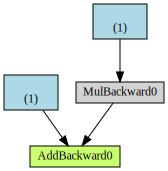

In [12]:
make_dot(yhat)

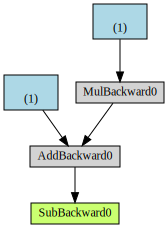

In [13]:
make_dot(error)

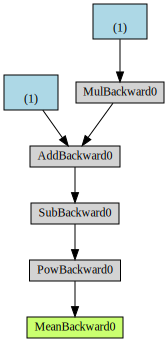

In [14]:
make_dot(loss)

blue is the parameter
gray is operation
green is same as grey but the last value (starting point for computation)


## Optimizer

Okay now for it to compute it all we need optimizer. For example SGD or Adam.

optimizer receive parameter and learning rate to perform step()

Also we dont have to use zero_() instead we use zero_grad()

In the code we use stochastic grad descent()

note: eventhough we specify to use all data in update it is still using batch.

In [15]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


nice it works, next.

# Loss

pytorch had a lot of option for loss. since now is regression therefore we using MSE.

note: there is nn.MSELoss function. however its not loss function itself but you have to reduce using mean or sum.

here is the code.

In [16]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


# Model

in pytorch model represent as extend of Module model.

The most important function to implement are __init__(self) and forward(self,x)

For this example.

__init__ is where we define a and b
forward is perform computation and give prediction.

note: in init we can specify not only parameter but layers, attributes etc
note: in forward we are not call forward, but we call model




In [17]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

notice that we use nn.Parameter for a and b.

by doing that we can call them later unsing parameters()

then we can call all value using state_dict()

importan: we need to send the model and data to same device



In [18]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='cuda:0')), ('b', tensor([0.1288], device='cuda:0'))])
OrderedDict([('a', tensor([1.0235], device='cuda:0')), ('b', tensor([1.9690], device='cuda:0'))])


Its done.

note: What is this? it is torch why to label that it is train phase. if it is not there the train performance will bad.


## Nested Model

last time we manually create manual regression. Now we create from pytorch module.

This is quite too similar with previous example but its okay.

lets see.

In [19]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

This way if you call the param it will called recursively.

## Sequential Models

If the model is simple we can use Sequential model.

model = nn.Sequential(nn.Linear(1, 1)).to(device)

## Training Step

now we have optimier, loss function and model.

This is the training code.



In [20]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())


OrderedDict([('a', tensor([1.0235], device='cuda:0')), ('b', tensor([1.9690], device='cuda:0'))])


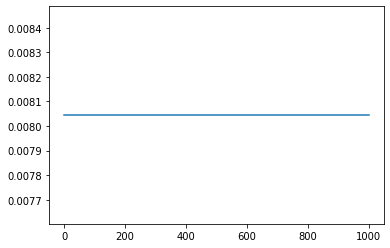

In [21]:
plt.plot(losses)
plt.show()